<a href="https://colab.research.google.com/github/Blanca-Vern-2nd/P-median-Optimization/blob/main/notebooks/Optimization_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pulp pandas numpy


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 93.3 MB/s eta 0:00:00


In [ ]:
import numpy as np
import random
from itertools import combinations
from math import radians, sin, cos, sqrt, atan2, exp
from pulp import LpProblem, LpMinimize, LpVariable, lpSum, LpBinary, PULP_CBC_CMD

# --- Haversine Distance ---
def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # Earth radius in km
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
    dlat, dlon = lat2 - lat1, lon2 - lon1
    a = sin(dlat/2)**2 + cos(lat1)*cos(lat2)*sin(dlon/2)**2
    return R * 2 * atan2(sqrt(a), sqrt(1 - a))

# --- Brute Force (for small n only!) ---
def brute_force_p_median(D, p):
    n = D.shape[0]
    best_cost = float('inf')
    best_meds = None
    for medoids in combinations(range(n), p):
        total_cost = np.min(D[:, list(medoids)], axis=1).sum()
        if total_cost < best_cost:
            best_cost = total_cost
            best_meds = list(medoids)
    return best_meds, best_cost

# --- ILP Solver ---
def ilp_p_median(D, p):
    n = D.shape[0]
    model = LpProblem("p-Median", LpMinimize)
    x = [[LpVariable(f"x_{i}_{j}", cat=LpBinary) for j in range(n)] for i in range(n)]
    y = [LpVariable(f"y_{j}", cat=LpBinary) for j in range(n)]

    model += lpSum(D[i][j] * x[i][j] for i in range(n) for j in range(n))
    for i in range(n):
        model += lpSum(x[i][j] for j in range(n)) == 1
        for j in range(n):
            model += x[i][j] <= y[j]
    model += lpSum(y[j] for j in range(n)) == p

    model.solve(PULP_CBC_CMD(msg=0))
    medoids = [j for j in range(n) if y[j].varValue == 1]
    cost = sum(D[i][j] * x[i][j].varValue for i in range(n) for j in range(n))
    return medoids, cost

# --- PAM (Partitioning Around Medoids) ---
def pam_p_median(D: np.ndarray, p: int, max_iter: int = 100) -> tuple[list[int], float]:
    if p < 1 or p > D.shape[0]:
        raise ValueError("p must be between 1 and number of points")

    n = D.shape[0]
    medoids = np.array(random.sample(range(n), p), dtype=int)
    best_cost = np.min(D[:, medoids], axis=1).sum()

    for _ in range(max_iter):
        improved = False
        for i in range(p):
            current = medoids[i]
            available = np.setdiff1d(np.arange(n), medoids)
            for candidate in available:
                medoids[i] = candidate
                new_cost = np.min(D[:, medoids], axis=1).sum()
                if new_cost < best_cost:
                    best_cost = new_cost
                    improved = True
                    break
            if improved:
                break
            medoids[i] = current
        if not improved:
            break

    return medoids.tolist(), best_cost


# --- Greedy ---
def greedy_p_median(D, p):
    n = D.shape[0]
    medoids = []
    while len(medoids) < p:
        best_gain, best_index = float('inf'), None
        for i in range(n):
            if i in medoids:
                continue
            trial = medoids + [i]
            total_cost = np.min(D[:, trial], axis=1).sum()
            if total_cost < best_gain:
                best_gain = total_cost
                best_index = i
        medoids.append(best_index)
    cost = np.min(D[:, medoids], axis=1).sum()
    return medoids, cost

# --- Genetic Algorithm ---
def genetic_algorithm_p_median(D, p, pop_size=500, generations=100, mutation_rate=0.2):
    n = D.shape[0]
    def fitness(meds): return np.min(D[:, meds], axis=1).sum()

    population = [random.sample(range(n), p) for _ in range(pop_size)]
    for _ in range(generations):
        population = sorted(population, key=fitness)
        next_gen = population[:10]  # Elitism
        while len(next_gen) < pop_size:
            parents = random.sample(population[:20], 2)
            child = list(set(parents[0][:p//2] + parents[1][p//2:]))
            while len(child) < p:
                r = random.randint(0, n-1)
                if r not in child:
                    child.append(r)
            if random.random() < mutation_rate:
                swap_out = random.choice(child)
                swap_in = random.choice([x for x in range(n) if x not in child])
                child[child.index(swap_out)] = swap_in
            next_gen.append(child)
        population = next_gen
    best = min(population, key=fitness)
    return best, fitness(best)

# --- Simulated Annealing ---
def simulated_annealing_p_median(D, p, T0=1000, alpha=0.90, iter_per_temp=200, min_temp=1e-2):
    n = D.shape[0]
    current = random.sample(range(n), p)
    def fitness(meds): return np.min(D[:, meds], axis=1).sum()
    current_cost = fitness(current)
    best, best_cost = current[:], current_cost
    T = T0

    while T > min_temp:
        for _ in range(iter_per_temp):
            i = random.randrange(p)
            non_meds = [x for x in range(n) if x not in current]
            j = random.choice(non_meds)
            candidate = current[:]
            candidate[i] = j
            cand_cost = fitness(candidate)
            Δ = cand_cost - current_cost
            if Δ < 0 or random.random() < exp(-Δ / T):
                current, current_cost = candidate, cand_cost
                if cand_cost < best_cost:
                    best, best_cost = candidate, cand_cost
        T *= alpha
    return best, best_cost


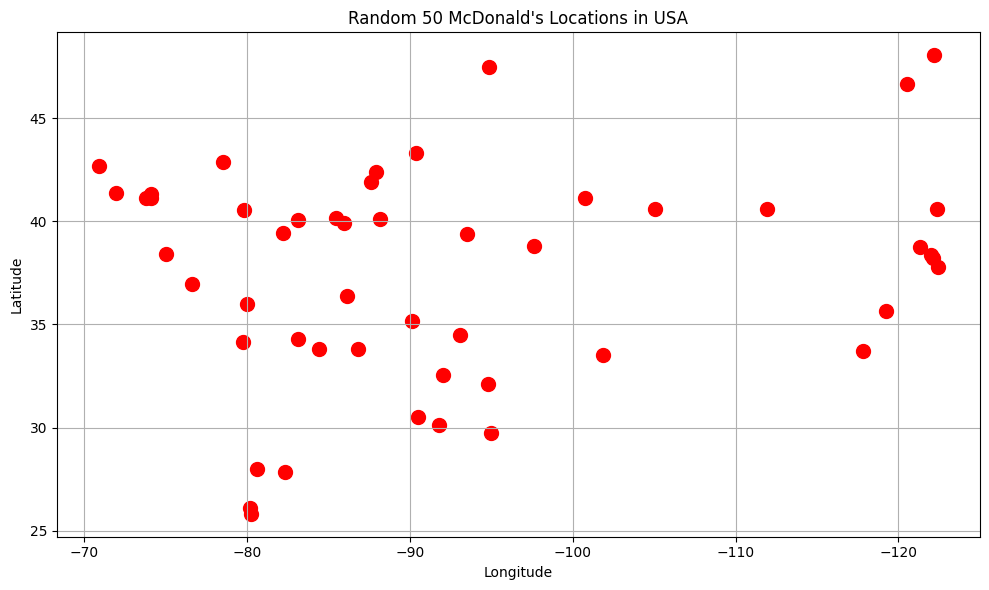

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('/content/mcdonalds_locations.csv')
df_subset = df.sample(n=50, random_state=42)
plt.figure(figsize=(10, 6))
plt.scatter(df_subset['longitude'], df_subset['latitude'], color='red', s=100)

plt.title("Random 50 McDonald's Locations in USA")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(True)
plt.gca().invert_xaxis()
plt.tight_layout()
plt.show()



Done with size 50 in 0.26 seconds

Done with size 100 in 2.13 seconds

Done with size 150 in 8.48 seconds

Done with size 200 in 18.13 seconds

Done with size 250 in 37.87 seconds

Done with size 300 in 66.95 seconds


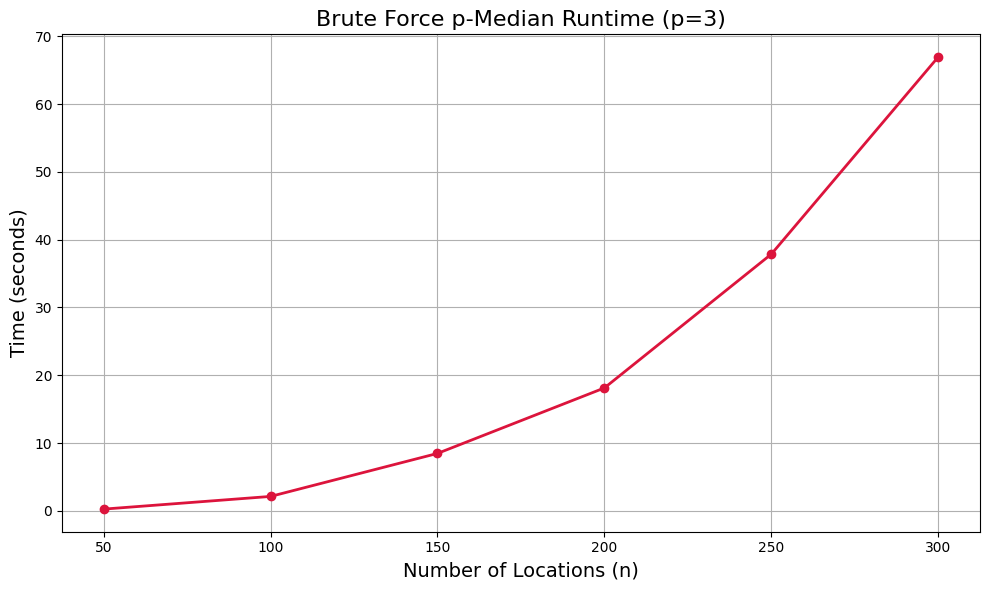

In [ ]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
from itertools import combinations
df = pd.read_csv('/content/mcdonalds_locations.csv')
subset_sizes = [50, 100, 150, 200, 250, 300]
times = []
results = []

for size in subset_sizes:
    if len(df) < size:
        print(f"Only {len(df)} entries available, skipping size {size}")
        continue
    df_subset = df.sample(n=size, random_state=42).reset_index(drop=True)
    coords = df_subset[['latitude', 'longitude']].values
    D = np.zeros((size, size))
    for i in range(size):
        for j in range(size):
            D[i][j] = haversine(*coords[i], *coords[j])
    start_time = time.time()
    medoids, min_total_distance = brute_force_p_median(D, p=3)
    elapsed = time.time() - start_time

    times.append(elapsed)
    results.append({
        'size': size,
        'min_total_distance': min_total_distance,
        'best_median_indices': medoids
    })

    print(f"\nDone with size {size} in {elapsed:.2f} seconds")

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(subset_sizes[:len(times)], times, marker='o', color='crimson', linewidth=2)
plt.title('Brute Force p-Median Runtime (p=3)', fontsize=16)
plt.xlabel('Number of Locations (n)', fontsize=14)
plt.ylabel('Time (seconds)', fontsize=14)
plt.grid(True)
plt.tight_layout()
plt.show()



Done with size 50 in 0.63 seconds

Done with size 100 in 5.64 seconds

Done with size 150 in 6.55 seconds

Done with size 200 in 20.96 seconds

Done with size 250 in 57.24 seconds

Done with size 300 in 126.47 seconds


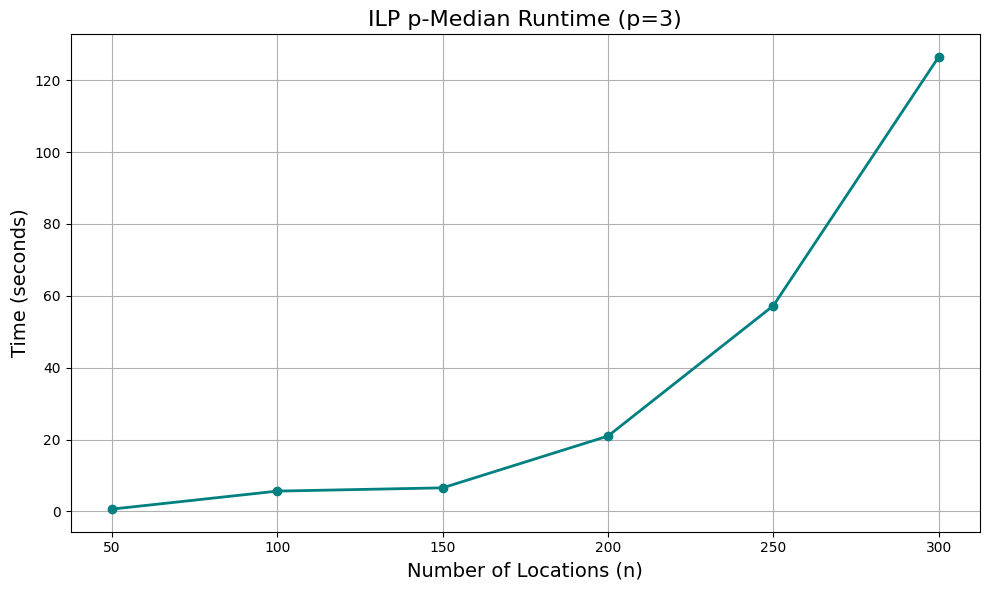

In [ ]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
df = pd.read_csv('/content/mcdonalds_locations.csv')
subset_sizes = [50, 100, 150, 200, 250, 300]
times = []
results = []
for size in subset_sizes:
    if len(df) < size:
        print(f"Only {len(df)} entries available, skipping size {size}")
        continue
    df_subset = df.sample(n=size, random_state=42).reset_index(drop=True)
    coords = df_subset[['latitude', 'longitude']].values

    D = np.zeros((size, size))
    for i in range(size):
        for j in range(size):
            D[i][j] = haversine(*coords[i], *coords[j])

    start_time = time.time()
    medoids, min_total_distance = ilp_p_median(D, p=3)
    elapsed = time.time() - start_time

    times.append(elapsed)
    results.append({
        'size': size,
        'min_total_distance': min_total_distance,
        'best_median_indices': medoids
    })

    print(f"\nDone with size {size} in {elapsed:.2f} seconds")
plt.figure(figsize=(10, 6))
plt.plot(subset_sizes[:len(times)], times, marker='o', color='teal', linewidth=2)
plt.title('ILP p-Median Runtime (p=3)', fontsize=16)
plt.xlabel('Number of Locations (n)', fontsize=14)
plt.ylabel('Time (seconds)', fontsize=14)
plt.grid(True)
plt.tight_layout()
plt.show()



===== GREEDY vs ILP Comparison (Randomized) =====

GREEDY n=50 | Time: 0.00s | Total Dist: 32010.99 km
  - URBANA-PHILO (40.097377, -88.191191)
  - FOOTHILL & JUNCT (38.750172, -121.309891)
  - SMITHFIELD (36.964133, -76.605686)

ILP    n=50 | Time: 1.22s | Total Dist: 30062.83 km
  - NELSONVILLE (39.4579, -82.2287)
  - MONROE LA (32.528278, -92.037618)
  - FOOTHILL & JUNCT (38.750172, -121.309891)

GREEDY n=100 | Time: 0.01s | Total Dist: 63759.89 km
  - URBANA-PHILO (40.097377, -88.191191)
  - FOOTHILL & JUNCT (38.750172, -121.309891)
  - RT. 197 & CONTEE (39.074506, -76.849073)

ILP    n=100 | Time: 8.76s | Total Dist: 63471.25 km
  - W. MEMPHIS-PETRO (35.153138, -90.136709)
  - FOOTHILL & JUNCT (38.750172, -121.309891)
  - SHREWSBURY (39.770639, -76.670352)

GREEDY n=150 | Time: 0.01s | Total Dist: 94719.57 km
  - HANLEY (38.773857, -90.335791)
  - FOOTHILL & JUNCT (38.750172, -121.309891)
  - RT. 197 & CONTEE (39.074506, -76.849073)

ILP    n=150 | Time: 6.05s | Total Dist: 93882

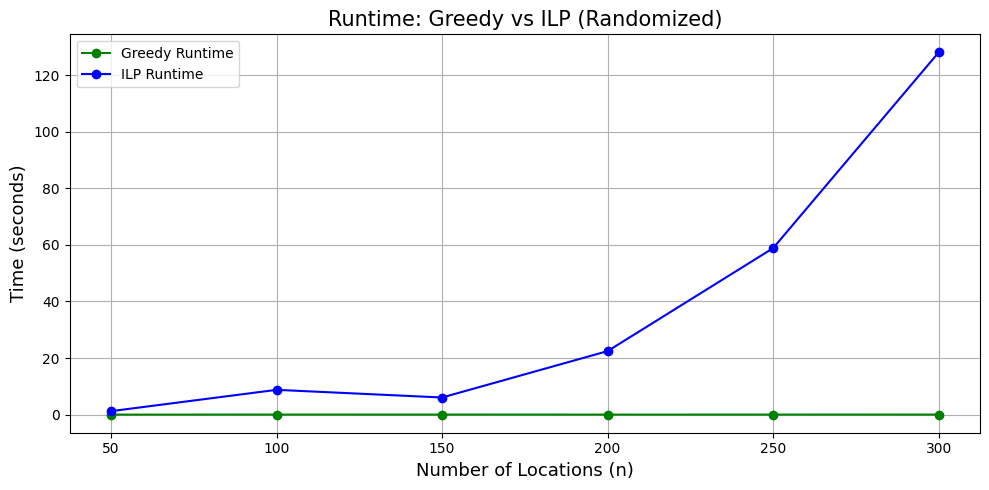

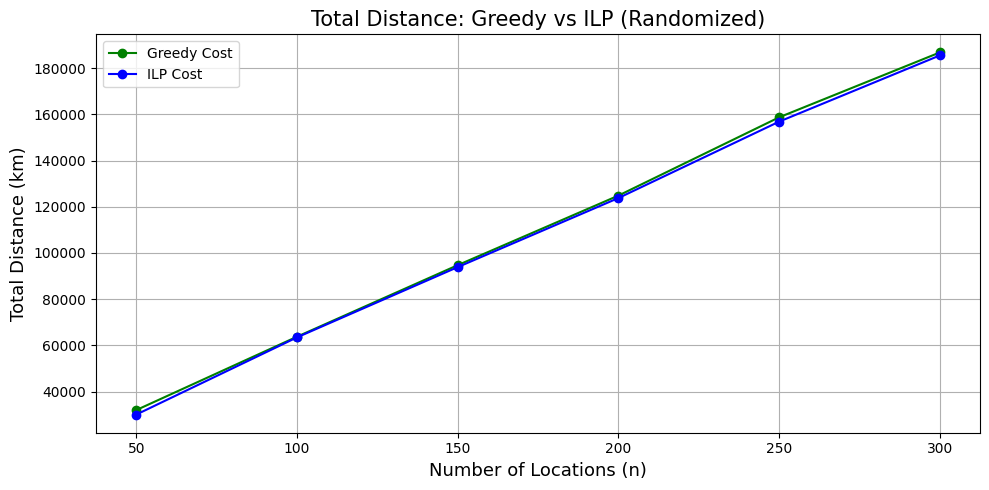

In [ ]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
from itertools import combinations
df = pd.read_csv('/content/mcdonalds_locations.csv')
subset_sizes = [50,100,150,200,250,300]
p = 3
greedy_times, greedy_costs = [], []
ilp_times, ilp_costs = [], []

print("\n===== GREEDY vs ILP Comparison (Randomized) =====")
for size in subset_sizes:
    if len(df) < size:
        continue
    df_subset = df.sample(n=size, random_state=42).reset_index(drop=True)
    coords = df_subset[['latitude', 'longitude']].values
    n = len(coords)

    D = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            D[i][j] = haversine(*coords[i], *coords[j])


    start = time.time()
    medians, greedy_total = greedy_p_median(D, p)
    greedy_time = time.time() - start

    greedy_times.append(greedy_time)
    greedy_costs.append(greedy_total)

    print(f"\nGREEDY n={size} | Time: {greedy_time:.2f}s | Total Dist: {greedy_total:.2f} km")
    for j in medians:
        loc = df_subset.iloc[j]
        print(f"  - {loc['name']} ({loc['latitude']}, {loc['longitude']})")


    start = time.time()
    medoids, ilp_total = ilp_p_median(D, p)
    ilp_time = time.time() - start

    ilp_times.append(ilp_time)
    ilp_costs.append(ilp_total)

    print(f"\nILP    n={size} | Time: {ilp_time:.2f}s | Total Dist: {ilp_total:.2f} km")
    for j in medoids:
        loc = df_subset.iloc[j]
        print(f"  - {loc['name']} ({loc['latitude']}, {loc['longitude']})")

# PLOT: RUNTIME
plt.figure(figsize=(10, 5))
plt.plot(subset_sizes, greedy_times, 'o-g', label='Greedy Runtime')
plt.plot(subset_sizes, ilp_times, 'o-b', label='ILP Runtime')
plt.xlabel("Number of Locations (n)", fontsize=13)
plt.ylabel("Time (seconds)", fontsize=13)
plt.title("Runtime: Greedy vs ILP (Randomized)", fontsize=15)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# PLOT: COST
plt.figure(figsize=(10, 5))
plt.plot(subset_sizes, greedy_costs, 'o-g', label='Greedy Cost')
plt.plot(subset_sizes, ilp_costs, 'o-b', label='ILP Cost')
plt.xlabel("Number of Locations (n)", fontsize=13)
plt.ylabel("Total Distance (km)", fontsize=13)
plt.title("Total Distance: Greedy vs ILP (Randomized)", fontsize=15)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()



PAM    n=50 | Time: 0.01s | Total Dist: 30062.83 km
  - FOOTHILL & JUNCT (38.7502, -121.3099)
  - NELSONVILLE (39.4579, -82.2287)
  - MONROE LA (32.5283, -92.0376)

ILP    n=50 | Time: 0.51s | Total Dist: 30062.83 km
  - NELSONVILLE (39.4579, -82.2287)
  - MONROE LA (32.5283, -92.0376)
  - FOOTHILL & JUNCT (38.7502, -121.3099)

PAM    n=100 | Time: 0.04s | Total Dist: 63685.82 km
  - HENDERSON-HWY 79 (32.1327, -94.8047)
  - FOOTHILL & JUNCT (38.7502, -121.3099)
  - NELSONVILLE (39.4579, -82.2287)

ILP    n=100 | Time: 5.76s | Total Dist: 63471.25 km
  - W. MEMPHIS-PETRO (35.1531, -90.1367)
  - FOOTHILL & JUNCT (38.7502, -121.3099)
  - SHREWSBURY (39.7706, -76.6704)

PAM    n=150 | Time: 0.02s | Total Dist: 94719.57 km
  - HANLEY (38.7739, -90.3358)
  - FOOTHILL & JUNCT (38.7502, -121.3099)
  - RT. 197 & CONTEE (39.0745, -76.8491)

ILP    n=150 | Time: 6.06s | Total Dist: 93882.11 km
  - NELSONVILLE (39.4579, -82.2287)
  - FOOTHILL & JUNCT (38.7502, -121.3099)
  - TERRELL TX (32.7381, 

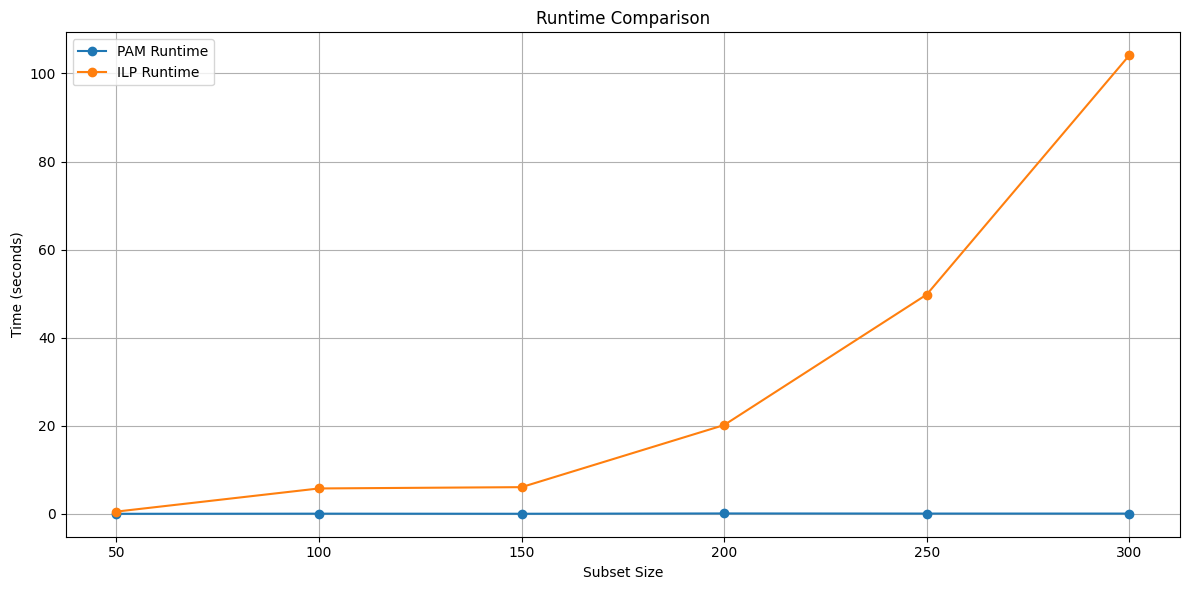

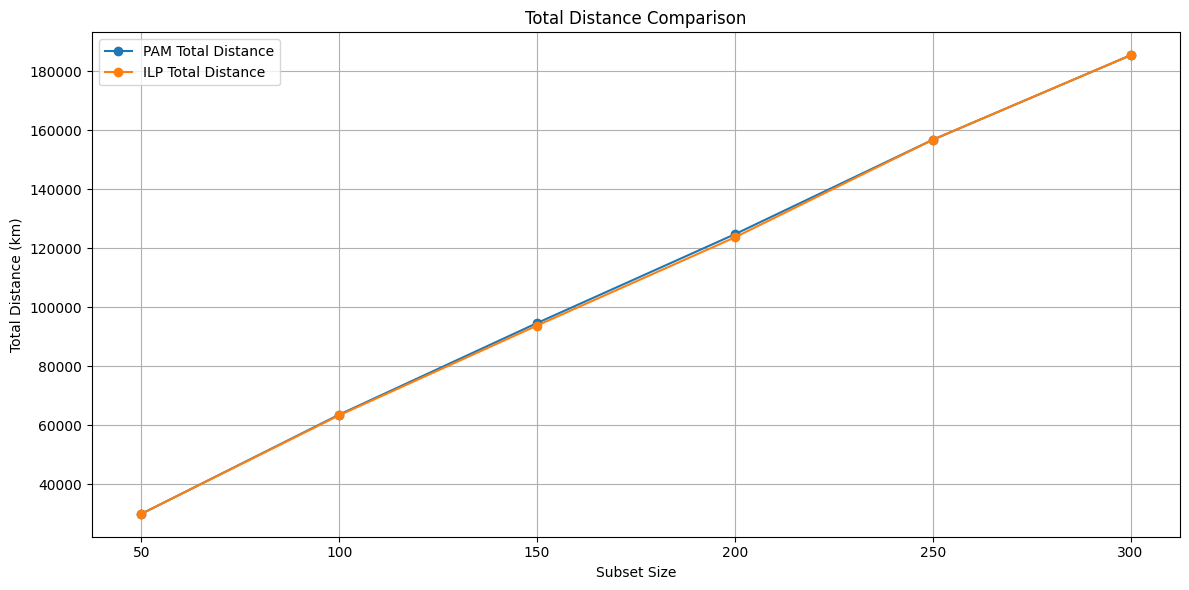

In [ ]:
subset_sizes = [50,100,150,200,250,300]
p = 3

pam_times, pam_costs = [], []
ilp_times, ilp_costs = [], []

for size in subset_sizes:
    if len(df) < size:
        continue

    df_subset = df.sample(n=size, random_state=42).reset_index(drop=True)
    coords = df_subset[['latitude', 'longitude']].values
    n = len(coords)

    D = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            D[i][j] = haversine(coords[i][0],coords[i][1],coords[j][0],coords[j][1])

    start = time.time()
    pam_medoids, pam_cost = pam_p_median(D, p)
    pam_time = time.time() - start
    pam_times.append(pam_time)
    pam_costs.append(pam_cost)

    print(f"\nPAM    n={size} | Time: {pam_time:.2f}s | Total Dist: {pam_cost:.2f} km")
    for j in pam_medoids:
        loc = df_subset.iloc[j]
        print(f"  - {loc['name']} ({loc['latitude']:.4f}, {loc['longitude']:.4f})")

    start = time.time()
    ilp_medoids, ilp_cost = ilp_p_median(D, p)
    ilp_time = time.time() - start
    ilp_times.append(ilp_time)
    ilp_costs.append(ilp_cost)

    print(f"\nILP    n={size} | Time: {ilp_time:.2f}s | Total Dist: {ilp_cost:.2f} km")
    for j in ilp_medoids:
        loc = df_subset.iloc[j]
        print(f"  - {loc['name']} ({loc['latitude']:.4f}, {loc['longitude']:.4f})")


plt.figure(figsize=(12, 6))
plt.plot(subset_sizes[:len(pam_times)], pam_times, label='PAM Runtime', marker='o')
plt.plot(subset_sizes[:len(ilp_times)], ilp_times, label='ILP Runtime', marker='o')
plt.title('Runtime Comparison')
plt.xlabel('Subset Size')
plt.ylabel('Time (seconds)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(subset_sizes[:len(pam_costs)], pam_costs, label='PAM Total Distance', marker='o')
plt.plot(subset_sizes[:len(ilp_costs)], ilp_costs, label='ILP Total Distance', marker='o')
plt.title('Total Distance Comparison')
plt.xlabel('Subset Size')
plt.ylabel('Total Distance (km)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



Genetic   n=50 | Time: 0.92s | Cost: 30062.83 km
  - NELSONVILLE (39.4579, -82.2287)
  - FOOTHILL & JUNCT (38.750172, -121.309891)
  - MONROE LA (32.528278, -92.037618)

ILP       n=50 | Time: 0.31s | Cost: 30062.83 km
  - NELSONVILLE (39.4579, -82.2287)
  - MONROE LA (32.528278, -92.037618)
  - FOOTHILL & JUNCT (38.750172, -121.309891)

Genetic   n=100 | Time: 0.89s | Cost: 63471.25 km
  - W. MEMPHIS-PETRO (35.153138, -90.136709)
  - SHREWSBURY (39.770639, -76.670352)
  - FOOTHILL & JUNCT (38.750172, -121.309891)

ILP       n=100 | Time: 6.59s | Cost: 63471.25 km
  - W. MEMPHIS-PETRO (35.153138, -90.136709)
  - FOOTHILL & JUNCT (38.750172, -121.309891)
  - SHREWSBURY (39.770639, -76.670352)

Genetic   n=150 | Time: 0.91s | Cost: 93882.11 km
  - FOOTHILL & JUNCT (38.750172, -121.309891)
  - NELSONVILLE (39.4579, -82.2287)
  - TERRELL TX (32.738077, -96.303964)

ILP       n=150 | Time: 5.65s | Cost: 93882.11 km
  - NELSONVILLE (39.4579, -82.2287)
  - FOOTHILL & JUNCT (38.750172, -121.3

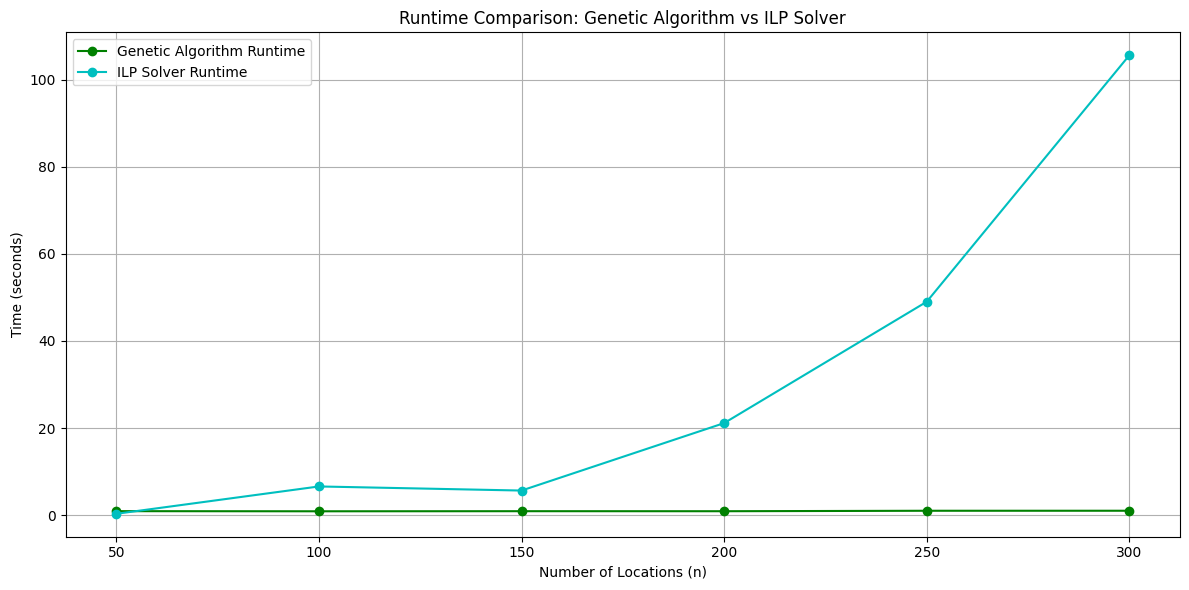

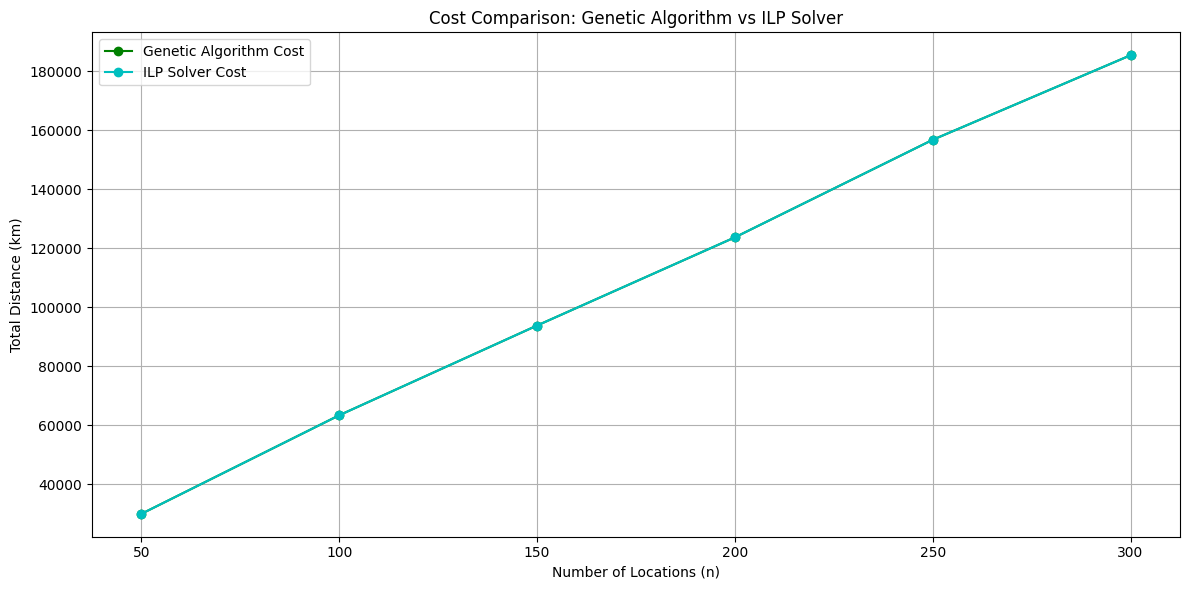

In [ ]:
subset_sizes = [50,100,150,200,250,300]
p = 3
ga_times,ga_costs,ilp_times,ilp_costs=[],[],[],[]

for size in subset_sizes:
    if len(df) < size:
        continue

    df_subset = df.sample(n=size, random_state=42).reset_index(drop=True)
    coords = df_subset[['latitude', 'longitude']].values
    n = len(coords)

    D = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            D[i][j] = haversine(*coords[i], *coords[j])

    start = time.time()
    ga_medoids, ga_cost = genetic_algorithm_p_median(D, p)
    ga_time = time.time() - start
    ga_times.append(ga_time)
    ga_costs.append(ga_cost)

    print(f"\nGenetic   n={size} | Time: {ga_time:.2f}s | Cost: {ga_cost:.2f} km")
    for j in ga_medoids:
        loc = df_subset.iloc[j]
        print(f"  - {loc['name']} ({loc['latitude']}, {loc['longitude']})")

    start = time.time()
    ilp_medoids, ilp_cost = ilp_p_median(D, p)
    ilp_time = time.time() - start
    ilp_times.append(ilp_time)
    ilp_costs.append(ilp_cost)

    print(f"\nILP       n={size} | Time: {ilp_time:.2f}s | Cost: {ilp_cost:.2f} km")
    for j in ilp_medoids:
        loc = df_subset.iloc[j]
        print(f"  - {loc['name']} ({loc['latitude']}, {loc['longitude']})")
# === Plot: Runtime Comparison ===
plt.figure(figsize=(12, 6))
plt.plot(subset_sizes, ga_times, 'o-g', label='Genetic Algorithm Runtime')
plt.plot(subset_sizes, ilp_times, 'o-c', label='ILP Solver Runtime')
plt.xlabel("Number of Locations (n)")
plt.ylabel("Time (seconds)")
plt.title("Runtime Comparison: Genetic Algorithm vs ILP Solver")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# === Plot: Cost Comparison ===
plt.figure(figsize=(12, 6))
plt.plot(subset_sizes, ga_costs, 'o-g', label='Genetic Algorithm Cost')
plt.plot(subset_sizes, ilp_costs, 'o-c', label='ILP Solver Cost')
plt.xlabel("Number of Locations (n)")
plt.ylabel("Total Distance (km)")
plt.title("Cost Comparison: Genetic Algorithm vs ILP Solver")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()



===== Simulated Annealing vs ILP =====

SA        n=50 | Time: 1.48s | Cost: 30062.83 km
  - 32.528278, -92.037618
  - 39.4579, -82.2287
  - 38.750172, -121.309891

ILP       n=50 | Time: 0.52s | Cost: 30062.83 km
  - 39.4579, -82.2287
  - 32.528278, -92.037618
  - 38.750172, -121.309891

SA        n=100 | Time: 1.29s | Cost: 63471.25 km
  - 38.750172, -121.309891
  - 39.770639, -76.670352
  - 35.153138, -90.136709

ILP       n=100 | Time: 5.50s | Cost: 63471.25 km
  - 35.153138, -90.136709
  - 38.750172, -121.309891
  - 39.770639, -76.670352

SA        n=150 | Time: 1.54s | Cost: 93882.11 km
  - 38.750172, -121.309891
  - 32.738077, -96.303964
  - 39.4579, -82.2287

ILP       n=150 | Time: 6.30s | Cost: 93882.11 km
  - 39.4579, -82.2287
  - 38.750172, -121.309891
  - 32.738077, -96.303964

SA        n=200 | Time: 1.47s | Cost: 123767.67 km
  - 36.85188, -119.728935
  - 38.794386, -90.623272
  - 39.074506, -76.849073

ILP       n=200 | Time: 19.62s | Cost: 123767.67 km
  - 39.074506, 

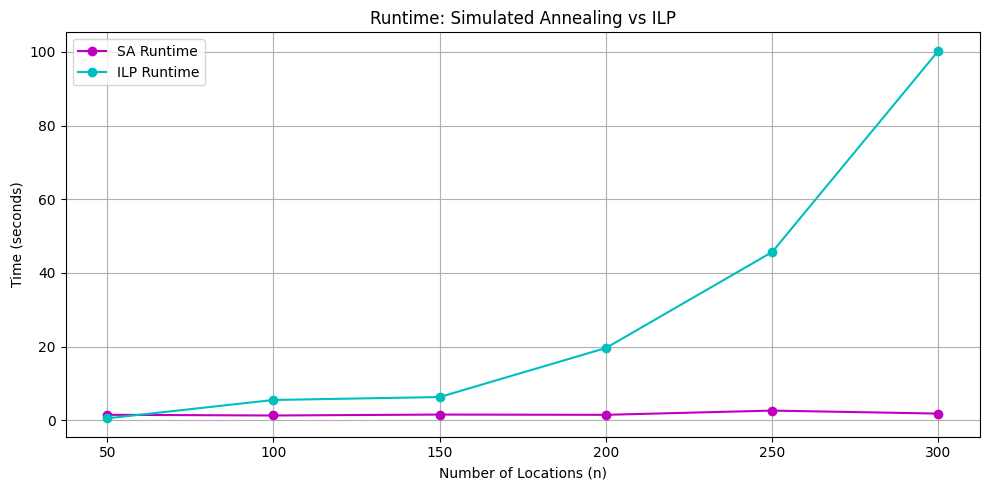

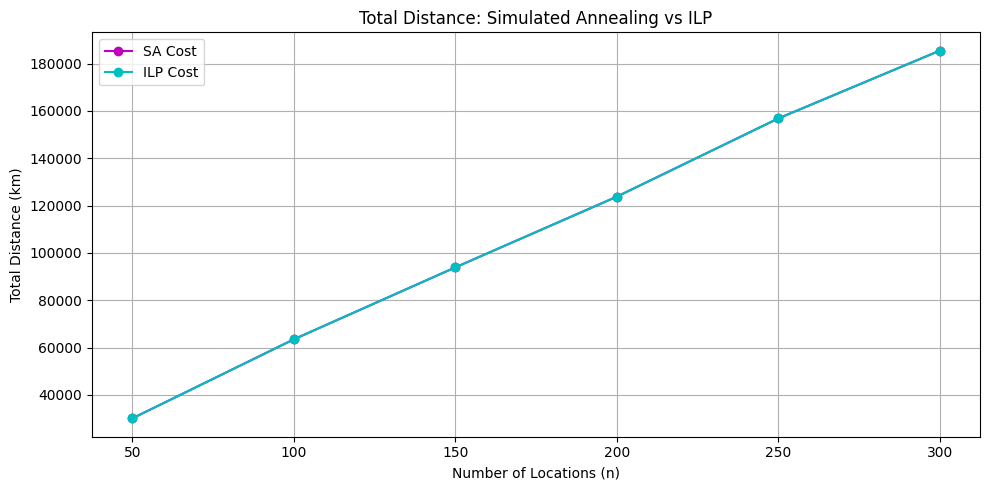

In [ ]:
df = pd.read_csv('/content/mcdonalds_locations.csv')
subset_sizes = [50, 100, 150, 200, 250, 300]
p = 3
random.seed(42)
np.random.seed(42)

sa_times, sa_costs = [], []
ilp_times, ilp_costs = [], []

print("\n===== Simulated Annealing vs ILP =====")
for size in subset_sizes:
    if len(df) < size:
        continue
    df_subset = df.sample(n=size, random_state=42).reset_index(drop=True)
    coords = df_subset[['latitude', 'longitude']].values
    n = len(coords)
    D = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            D[i][j] = haversine(*coords[i], *coords[j])

    # --- Simulated Annealing ---
    start = time.time()
    sa_medoids, sa_cost = simulated_annealing_p_median(D, p,
                                                       T0=1000, alpha=0.95,
                                                       iter_per_temp=200, min_temp=1e-2)
    sa_time = time.time() - start
    sa_times.append(sa_time)
    sa_costs.append(sa_cost)

    print(f"\nSA        n={size} | Time: {sa_time:.2f}s | Cost: {sa_cost:.2f} km")
    for j in sa_medoids:
        loc = df_subset.iloc[j]
        print(f"  - {loc['latitude']}, {loc['longitude']}")

    # --- ILP ---
    start = time.time()
    ilp_medoids, ilp_cost = ilp_p_median(D, p)
    ilp_time = time.time() - start
    ilp_times.append(ilp_time)
    ilp_costs.append(ilp_cost)

    print(f"\nILP       n={size} | Time: {ilp_time:.2f}s | Cost: {ilp_cost:.2f} km")
    for j in ilp_medoids:
        loc = df_subset.iloc[j]
        print(f"  - {loc['latitude']}, {loc['longitude']}")

# === Plot: Runtime ===
plt.figure(figsize=(10, 5))
plt.plot(subset_sizes, sa_times, 'o-m', label='SA Runtime')
plt.plot(subset_sizes, ilp_times, 'o-c', label='ILP Runtime')
plt.xlabel("Number of Locations (n)")
plt.ylabel("Time (seconds)")
plt.title("Runtime: Simulated Annealing vs ILP")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# === Plot: Cost ===
plt.figure(figsize=(10, 5))
plt.plot(subset_sizes, sa_costs, 'o-m', label='SA Cost')
plt.plot(subset_sizes, ilp_costs, 'o-c', label='ILP Cost')
plt.xlabel("Number of Locations (n)")
plt.ylabel("Total Distance (km)")
plt.title("Total Distance: Simulated Annealing vs ILP")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

Results for n=1000:
Greedy: Time=0.0844s, Cost=628748.10 km
PAM: Time=1.3150s, Cost=619262.86 km
GA: Time=2.8375s, Cost=621917.32 km
SA: Time=3.7066s, Cost=616372.91 km
----------------------------------------
Results for n=1250:
Greedy: Time=0.1616s, Cost=778210.81 km
PAM: Time=1.8032s, Cost=767857.99 km
GA: Time=4.3420s, Cost=769950.94 km
SA: Time=4.8484s, Cost=772512.12 km
----------------------------------------
Results for n=1500:
Greedy: Time=0.2340s, Cost=938625.72 km
PAM: Time=1.8233s, Cost=914359.65 km
GA: Time=5.6614s, Cost=915931.92 km
SA: Time=4.8801s, Cost=916841.83 km
----------------------------------------
Results for n=1750:
Greedy: Time=0.3453s, Cost=1086016.94 km
PAM: Time=5.1650s, Cost=1073633.76 km
GA: Time=6.8614s, Cost=1064200.35 km
SA: Time=5.9318s, Cost=1068210.22 km
----------------------------------------
Results for n=2000:
Greedy: Time=0.4596s, Cost=1250222.65 km
PAM: Time=9.2240s, Cost=1220241.39 km
GA: Time=7.3951s, Cost=1220298.42 km
SA: Time=7.6647s, Co

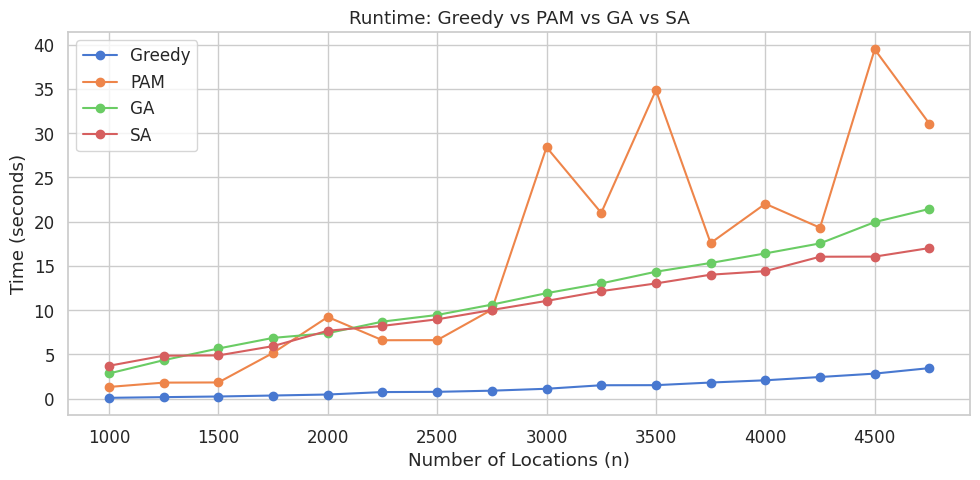

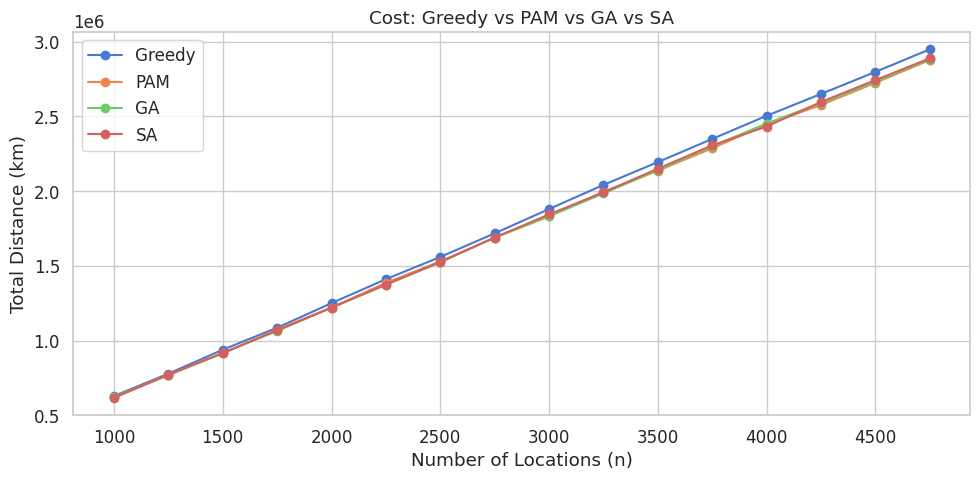

In [ ]:
import os
import pandas as pd
import numpy as np
import random
import time
import matplotlib.pyplot as plt
csv_path = 'mcdonalds_locations.csv'
if not os.path.exists(csv_path):
    raise FileNotFoundError(f"Place your CSV at ./{csv_path}")
df = pd.read_csv(csv_path)
subset_sizes = list(range(1000, 5000, 250))
p = 3
results = []
for n in subset_sizes:
    if len(df) < n:
        break

    sub = df.sample(n=n, random_state=42).reset_index(drop=True)
    coords = sub[['latitude','longitude']].values
    D = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            D[i,j] = haversine(coords[i,0], coords[i,1], coords[j,0], coords[j,1])
    st = time.time(); _, cost_g = greedy_p_median(D, p); t_g = time.time() - st
    st = time.time(); _, cost_p = pam_p_median(D, p);    t_p = time.time() - st
    st = time.time(); _, cost_ga = genetic_algorithm_p_median(D, p); t_ga = time.time() - st
    st = time.time(); _, cost_sa = simulated_annealing_p_median(D, p); t_sa = time.time() - st
    print(f"Results for n={n}:")
    print(f"Greedy: Time={t_g:.4f}s, Cost={cost_g:.2f} km")
    print(f"PAM: Time={t_p:.4f}s, Cost={cost_p:.2f} km")
    print(f"GA: Time={t_ga:.4f}s, Cost={cost_ga:.2f} km")
    print(f"SA: Time={t_sa:.4f}s, Cost={cost_sa:.2f} km")
    print("-" * 40)

    results.append({
        'n': n,
        'Greedy Time (s)': t_g, 'Greedy Cost (km)': cost_g,
        'PAM Time (s)':    t_p, 'PAM Cost (km)':    cost_p,
        'GA Time (s)':     t_ga,'GA Cost (km)':     cost_ga,
        'SA Time (s)':     t_sa,'SA Cost (km)':     cost_sa
    })

df_res = pd.DataFrame(results)
print(df_res.to_string(index=False))

# Plot: Runtime
plt.figure(figsize=(10,5))
for col,label in [('Greedy Time (s)','Greedy'),
                  ('PAM Time (s)','PAM'),
                  ('GA Time (s)','GA'),
                  ('SA Time (s)','SA')]:
    plt.plot(df_res['n'], df_res[col], marker='o', label=label)
plt.xlabel("Number of Locations (n)")
plt.ylabel("Time (seconds)")
plt.title("Runtime: Greedy vs PAM vs GA vs SA")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Plot: Cost
plt.figure(figsize=(10,5))
for col,label in [('Greedy Cost (km)','Greedy'),
                  ('PAM Cost (km)','PAM'),
                  ('GA Cost (km)','GA'),
                  ('SA Cost (km)','SA')]:
    plt.plot(df_res['n'], df_res[col], marker='o', label=label)
plt.xlabel("Number of Locations (n)")
plt.ylabel("Total Distance (km)")
plt.title("Cost: Greedy vs PAM vs GA vs SA")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


Results for p=5:
Greedy: Time=0.1798s, Cost=449334.45 km
PAM: Time=4.5368s, Cost=413024.15 km
GA: Time=4.1487s, Cost=413024.15 km
SA: Time=5.1697s, Cost=413096.16 km
----------------------------------------
Results for p=10:
Greedy: Time=0.5915s, Cost=281784.15 km
PAM: Time=30.9277s, Cost=265763.64 km
GA: Time=7.6574s, Cost=262297.90 km
SA: Time=6.4595s, Cost=261829.95 km
----------------------------------------
Results for p=15:
Greedy: Time=1.4857s, Cost=211256.44 km
PAM: Time=77.7394s, Cost=198447.86 km
GA: Time=10.1238s, Cost=196751.66 km
SA: Time=9.8215s, Cost=195325.06 km
----------------------------------------
Results for p=20:
Greedy: Time=2.1763s, Cost=172573.46 km
PAM: Time=53.4327s, Cost=178614.66 km
GA: Time=12.9347s, Cost=160368.72 km
SA: Time=12.2190s, Cost=159100.55 km
----------------------------------------
Results for p=25:
Greedy: Time=3.6464s, Cost=148449.76 km
PAM: Time=97.0423s, Cost=164910.83 km
GA: Time=16.3685s, Cost=137557.51 km
SA: Time=14.1018s, Cost=136338

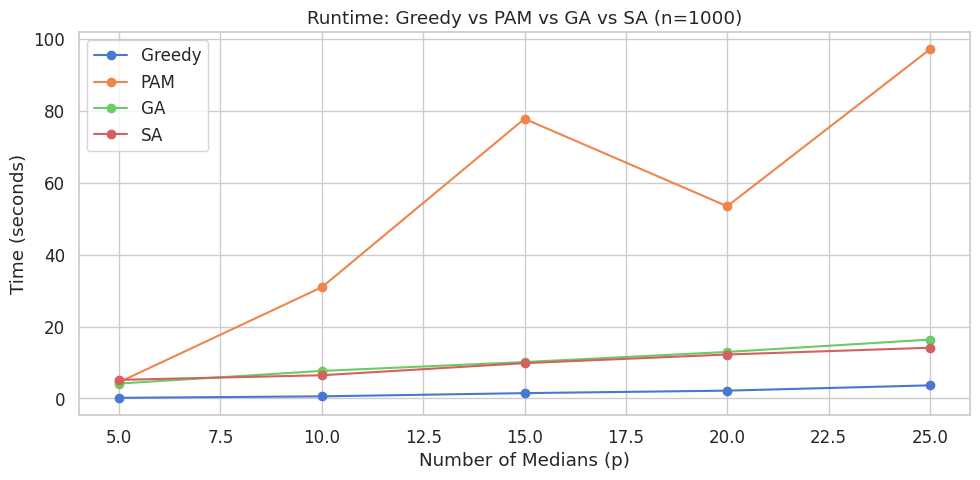

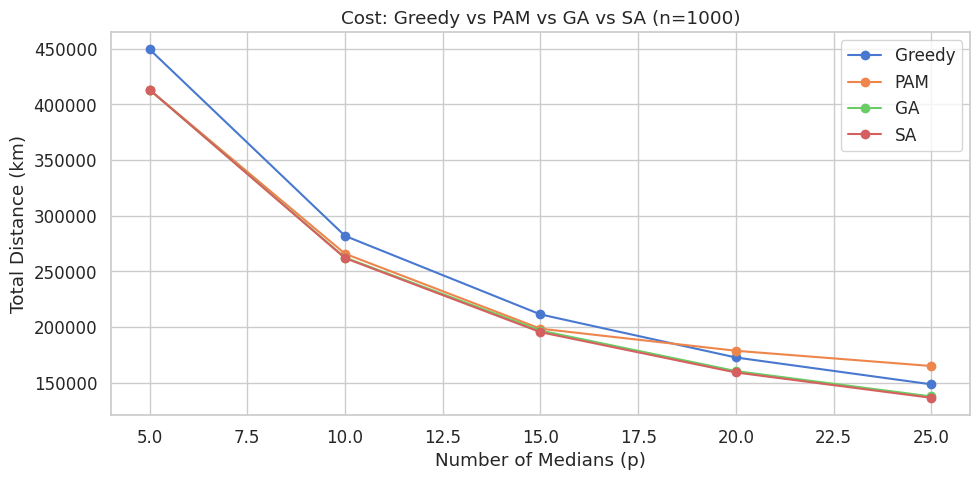

In [ ]:
df = pd.read_csv('/content/mcdonalds_locations.csv')
n = 1000
p_values = list(range(5, 30, 5))
results = []

sub = df.sample(n=n, random_state=42).reset_index(drop=True)
coords = sub[['latitude', 'longitude']].values

D = np.zeros((n, n))
for i in range(n):
    for j in range(n):
        D[i, j] = haversine(coords[i, 0], coords[i, 1], coords[j, 0], coords[j, 1])

for p in p_values:
    st = time.time(); _, cost_g = greedy_p_median(D, p); t_g = time.time() - st
    st = time.time(); _, cost_p = pam_p_median(D, p);    t_p = time.time() - st
    st = time.time(); _, cost_ga = genetic_algorithm_p_median(D, p); t_ga = time.time() - st
    st = time.time(); _, cost_sa = simulated_annealing_p_median(D, p); t_sa = time.time() - st
    print(f"Results for p={p}:")
    print(f"Greedy: Time={t_g:.4f}s, Cost={cost_g:.2f} km")
    print(f"PAM: Time={t_p:.4f}s, Cost={cost_p:.2f} km")
    print(f"GA: Time={t_ga:.4f}s, Cost={cost_ga:.2f} km")
    print(f"SA: Time={t_sa:.4f}s, Cost={cost_sa:.2f} km")
    print("-" * 40)

    results.append({
        'p': p,
        'Greedy Time (s)': t_g, 'Greedy Cost (km)': cost_g,
        'PAM Time (s)':    t_p, 'PAM Cost (km)':    cost_p,
        'GA Time (s)':     t_ga, 'GA Cost (km)':    cost_ga,
        'SA Time (s)':     t_sa, 'SA Cost (km)':    cost_sa
    })

df_res = pd.DataFrame(results)
print(df_res.to_string(index=False))

# Plot: Runtime
plt.figure(figsize=(10, 5))
for col, label in [('Greedy Time (s)', 'Greedy'),
                   ('PAM Time (s)', 'PAM'),
                   ('GA Time (s)', 'GA'),
                   ('SA Time (s)', 'SA')]:
    plt.plot(df_res['p'], df_res[col], marker='o', label=label)
plt.xlabel("Number of Medians (p)")
plt.ylabel("Time (seconds)")
plt.title("Runtime: Greedy vs PAM vs GA vs SA (n=1000)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Plot: Cost
plt.figure(figsize=(10, 5))
for col, label in [('Greedy Cost (km)', 'Greedy'),
                   ('PAM Cost (km)', 'PAM'),
                   ('GA Cost (km)', 'GA'),
                   ('SA Cost (km)', 'SA')]:
    plt.plot(df_res['p'], df_res[col], marker='o', label=label)
plt.xlabel("Number of Medians (p)")
plt.ylabel("Total Distance (km)")
plt.title("Cost: Greedy vs PAM vs GA vs SA (n=1000)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
data = [
    {'n': 1000, 'Greedy Time (s)': 0.084352, 'Greedy Cost (km)': 6.287481e+05, 'PAM Time (s)': 1.314986, 'PAM Cost (km)': 6.192629e+05, 'GA Time (s)': 2.837476, 'GA Cost (km)': 6.219173e+05, 'SA Time (s)': 3.706575, 'SA Cost (km)': 6.163729e+05},
    {'n': 1250, 'Greedy Time (s)': 0.161588, 'Greedy Cost (km)': 7.782108e+05, 'PAM Time (s)': 1.803242, 'PAM Cost (km)': 7.678580e+05, 'GA Time (s)': 4.342027, 'GA Cost (km)': 7.699509e+05, 'SA Time (s)': 4.848408, 'SA Cost (km)': 7.725121e+05},
    {'n': 1500, 'Greedy Time (s)': 0.233974, 'Greedy Cost (km)': 9.386257e+05, 'PAM Time (s)': 1.823254, 'PAM Cost (km)': 9.143597e+05, 'GA Time (s)': 5.661396, 'GA Cost (km)': 9.159319e+05, 'SA Time (s)': 4.880134, 'SA Cost (km)': 9.168418e+05},
    {'n': 1750, 'Greedy Time (s)': 0.345334, 'Greedy Cost (km)': 1.086017e+06, 'PAM Time (s)': 5.165045, 'PAM Cost (km)': 1.073634e+06, 'GA Time (s)': 6.861417, 'GA Cost (km)': 1.064200e+06, 'SA Time (s)': 5.931835, 'SA Cost (km)': 1.068210e+06},
    {'n': 2000, 'Greedy Time (s)': 0.459572, 'Greedy Cost (km)': 1.250223e+06, 'PAM Time (s)': 9.224008, 'PAM Cost (km)': 1.220241e+06, 'GA Time (s)': 7.395056, 'GA Cost (km)': 1.220298e+06, 'SA Time (s)': 7.664736, 'SA Cost (km)': 1.220241e+06},
    {'n': 2250, 'Greedy Time (s)': 0.734226, 'Greedy Cost (km)': 1.410895e+06, 'PAM Time (s)': 6.595417, 'PAM Cost (km)': 1.386514e+06, 'GA Time (s)': 8.699878, 'GA Cost (km)': 1.372497e+06, 'SA Time (s)': 8.218381, 'SA Cost (km)': 1.374945e+06},
    {'n': 2500, 'Greedy Time (s)': 0.761752, 'Greedy Cost (km)': 1.559630e+06, 'PAM Time (s)': 6.605929, 'PAM Cost (km)': 1.529101e+06, 'GA Time (s)': 9.452956, 'GA Cost (km)': 1.523457e+06, 'SA Time (s)': 8.959898, 'SA Cost (km)': 1.526653e+06},
    {'n': 2750, 'Greedy Time (s)': 0.892685, 'Greedy Cost (km)': 1.717571e+06, 'PAM Time (s)': 10.054460, 'PAM Cost (km)': 1.689167e+06, 'GA Time (s)': 10.621624, 'GA Cost (km)': 1.689296e+06, 'SA Time (s)': 10.016462, 'SA Cost (km)': 1.689296e+06},
    {'n': 3000, 'Greedy Time (s)': 1.108482, 'Greedy Cost (km)': 1.880305e+06, 'PAM Time (s)': 28.415450, 'PAM Cost (km)': 1.831273e+06, 'GA Time (s)': 11.916232, 'GA Cost (km)': 1.831484e+06, 'SA Time (s)': 11.041657, 'SA Cost (km)': 1.844372e+06},
    {'n': 3250, 'Greedy Time (s)': 1.506426, 'Greedy Cost (km)': 2.041635e+06, 'PAM Time (s)': 20.997181, 'PAM Cost (km)': 1.995818e+06, 'GA Time (s)': 13.019860, 'GA Cost (km)': 1.984780e+06, 'SA Time (s)': 12.144496, 'SA Cost (km)': 1.991765e+06},
    {'n': 3500, 'Greedy Time (s)': 1.516774, 'Greedy Cost (km)': 2.194522e+06, 'PAM Time (s)': 34.861609, 'PAM Cost (km)': 2.136760e+06, 'GA Time (s)': 14.341929, 'GA Cost (km)': 2.140417e+06, 'SA Time (s)': 13.018799, 'SA Cost (km)': 2.150138e+06},
    {'n': 3750, 'Greedy Time (s)': 1.812977, 'Greedy Cost (km)': 2.349712e+06, 'PAM Time (s)': 17.585318, 'PAM Cost (km)': 2.287330e+06, 'GA Time (s)': 15.330836, 'GA Cost (km)': 2.300743e+06, 'SA Time (s)': 14.005251, 'SA Cost (km)': 2.306882e+06},
    {'n': 4000, 'Greedy Time (s)': 2.066561, 'Greedy Cost (km)': 2.504360e+06, 'PAM Time (s)': 22.024747, 'PAM Cost (km)': 2.446643e+06, 'GA Time (s)': 16.412869, 'GA Cost (km)': 2.453112e+06, 'SA Time (s)': 14.405532, 'SA Cost (km)': 2.432638e+06},
    {'n': 4250, 'Greedy Time (s)': 2.437574, 'Greedy Cost (km)': 2.650719e+06, 'PAM Time (s)': 19.319715, 'PAM Cost (km)': 2.576890e+06, 'GA Time (s)': 17.543103, 'GA Cost (km)': 2.588653e+06, 'SA Time (s)': 16.037786, 'SA Cost (km)': 2.596942e+06},
    {'n': 4500, 'Greedy Time (s)': 2.821544, 'Greedy Cost (km)': 2.798150e+06, 'PAM Time (s)': 39.482584, 'PAM Cost (km)': 2.725382e+06, 'GA Time (s)': 19.949467, 'GA Cost (km)': 2.732616e+06, 'SA Time (s)': 16.048489, 'SA Cost (km)': 2.743418e+06},
    {'n': 4750, 'Greedy Time (s)': 3.443760, 'Greedy Cost (km)': 2.949551e+06, 'PAM Time (s)': 31.078249, 'PAM Cost (km)': 2.877388e+06, 'GA Time (s)': 21.442623, 'GA Cost (km)': 2.881977e+06, 'SA Time (s)': 17.017983, 'SA Cost (km)': 2.888896e+06}
]







